#### MLOps_Assignment_2_Grp_99
- 1. Arun Gupta (2024AB05335)
- 2. Ankur Gupta (2024AB05337)
- 3. Arjun Chandran (2024AB05336)
- 4. Vineet Suresh Kumar Yadav (2024AB05340)
- 5. Umang Nathani (2024AB05334)

##### Data pre-processing and spiliting.
- Pre-process to 224x224 RGB images for standard CNNs. Split into train/validation/test sets (e.g., 80%/10%/10%).
    
    Files added:
    - `preprocess_petimages.py` — main preprocessing script
    - `data_split.py` — data split script

    - Quick run:

        ```bash
        python preprocess_petimages.py --input data/Dataset/PetImages --output data/processed/PetImages_224 --method resize_crop --workers 8
        python data_split.py
        ```

##### M1:  Model Development & Experiment Tracking
- 1. Data & Code Versioning

        Use Git for source code versioning and Git‑LFS for dataset versioning and to track pre-processed data.
        File added to track data versioning:
        - `.gitattributes`
- 2. Model Building 

        Use simple CNN for model training and save the trained model in .keras format.
        File updated to track models(due to large model size):
        - `.gitattributes`
- 3. Experiment Tracking

        Use MLFlow to log runs, parameters, metrics, and artifacts (confusion matrix, loss curves)
        
        Files added:

        - `mlflow_workflow.py` — Train model and configure MLFlow

            ```bash
            python mlflow_workflow.py
            python mlflow_workflow.py --epochs 10
            mlflow ui --backend-store-uri mlruns --port 5000
            ```

        MLFlow UI screenshot added in folder:
        ```
        mlflow_screenshots
        ```

##### M2: Model Packaging & Containerization 
- 1. Inference Service

        Wrap the trained model with a simple REST API using FastAPI. 

        Files added:
        - `inference_service.py` — REST API to access model for inderence
        - `inference_client.py` — Inference client to validate the image

            ```bash
            python inference_service.py --port 8000 --model-uri "runs:/<run_id>/model"
            python inference_service.py --port 8000 --model-uri "runs:/a40b43613cdb458b93c2da1e0a723b02/model"
            python inference_client.py --image /path/to/image.jpg --mode file --url http://localhost:8000
            python inference_client.py --image /path/to/image.jpg --mode base64 --url http://localhost:8000
            ```
- 2. Environment Specification
        - `requirements.txt`
- 3. Containerization:
        - `Dockerfile`
        - `download_model.py`
        - `entrypoint.sh`
        - build image
            ```
            docker build -t pet-inference:latest .
            ```
        - run using an MLflow model URI (recommended)
            ```
            docker run -p 8000:8000 --rm -e MODEL_URI="runs:/<run_id>/model" pet-inference:latest
            ```
##### M3: CI Pipeline for Build, Test & Image Creation
- 1. Automated Testing

        Unit test using pytest

        Files added:
        - `tests/test_inference_utils.py` — REST API to access model for inference
        - `tests/test_preprocess.py` — Inference client to validate the image

            ```bash
            python -m pytest -q tests -q
            python -m pytest tests -vv > pytest_output.txt 2>&1
            ```
- 2. CI Setup (Choose one: GitHub Actions / GitLab CI / Jenkins / Tekton) 

        A GitHub Actions workflow has been added to run tests and build the Docker image:

        Workflow files:
        - `.github/workflows/ci.yml` (root) — generic repo CI
        - `.github/workflows/ci.yml` — runs tests and builds the subproject image
- 3. Artifact Publishing: 

        To enable pushing built images from CI, set one of the following repository secrets:

        - GitHub Container Registry (recommended): the workflow uses `GITHUB_TOKEN` but requires `packages: write` permission (already set in workflow).
        - For Docker Hub: set `DOCKERHUB_USERNAME` and `DOCKERHUB_PASSWORD` in repository Secrets.

            Local test / build commands:
            ```bash
            # Run unit tests locally
            python -m pytest -q MLOps_Assignment_2_Grp_99/tests
            # Build the Docker image locally (from repo root)
            docker build -t mlops-assignment2/pet-inference:latest -f MLOps_Assignment_2_Grp_99/Dockerfile MLOps_Assignment_2_Grp_99
            # Push to Docker Hub (optional)
            docker tag mlops-assignment2/pet-inference:latest <your-dockerhub-username>/mlops-assignment2:latest
            docker push <your-dockerhub-username>/mlops-assignment2:latest
            ```

##### M4: CD Pipeline & Deployment    
- 1. Deployment Target 
    
        A `docker-compose.yml` is provided to run the inference service and an optional MLflow UI. 
        
        To keep secrets out of source control, copy `.env.example` to `.env` and update values:

        ```bash
        cp MLOps_Assignment_2_Grp_99/.env.example MLOps_Assignment_2_Grp_99/.env
        # edit MLOps_Assignment_2_Grp_99/.env then start services
        docker-compose -f MLOps_Assignment_2_Grp_99/docker-compose.yml up --build -d
        # view logs
        docker-compose -f MLOps_Assignment_2_Grp_99/docker-compose.yml logs -f
        # stop services
        docker-compose -f MLOps_Assignment_2_Grp_99/docker-compose.yml down
        ```
- 2. CD / GitOps Flow 

        A GitHub Actions workflow has been added to automatically deploy the updated image to a remote server when `main` is updated.

        Workflow file: `MLOps_Assignment_2_Grp_99/.github/workflows/cd.yml`

        What the workflow does:
        - Runs on `push` to `main` and targets the `production` environment.
        - Uses an SSH private key (stored in `DEPLOY_SSH_KEY`) to connect to the deployment host.
        - Optionally logs in to Docker Hub on the remote host (if `DOCKERHUB_USERNAME`/`DOCKERHUB_PASSWORD` are set), then runs `docker-compose pull` and `docker-compose up -d` in the deployment path.
        - Verifies the inference health endpoint after deployment.

        Repository secrets required (set these in Settings → Secrets → Actions):
        - `DEPLOY_HOST`: the IP or hostname of the target server
        - `DEPLOY_USER`: SSH user on the server
        - `DEPLOY_PATH`: path on the server where `docker-compose.yml` lives (e.g., `/srv/pet-inference`)
        - `DEPLOY_SSH_KEY`: private SSH key (PEM) for `DEPLOY_USER`
        - `DEPLOY_SSH_PORT`: optional (default 22)

        Manual deploy test commands (on the target host):

        ```bash
        # login (if needed)
        docker login -u <user> -p '<password>'
        # update and restart with docker-compose (run in DEPLOY_PATH)
        docker-compose pull
        docker-compose up -d --remove-orphans
        # check health locally on host
        curl http://localhost:8000/health
        ```
- 3. Smoke Tests / Health Check 

        - Verify endpoints:

            ```bash
            curl http://localhost:8000/health
            curl -X POST "http://localhost:8000/predict" -F "files=@data/processed/PetImages_224_split/test/Cat/<image>.jpg"
            ```

##### M5: Monitoring, Logs & Final Submission    
- 1. Basic Monitoring & Logging 

        Logging added to inference service and logs are created in:
        - `inference.log`
- 2. Model Performance Tracking (Post‑Deployment) 

        A small helper script is provided to collect a batch of requests (images) against the running inference service and store the responses together with true labels for later analysis.

        Script: `monitoring/collect_requests.py`

        Usage example (from repo root):
        ```bash
        # collect up to 100 images per class from the test split and post to local service
        python monitoring/collect_requests.py --url http://localhost:8000 --image-dir data/processed/PetImages_224_split/test --output monitoring/results.csv --limit 100
        ```

        Output: CSV (`monitoring/results.csv`) with columns: `image_path`, `true_label`, `status_code`, `predicted_label`, `response_json`. 

##### Sample Run

- Start MLFlow UI:

    ```bash
        mlflow ui --backend-store-uri file:///C:/ArunDocs/Code/MLOps_Assignment_2_Grp_99/mlruns --port 5000
    ```

- Start Inference Service for model with run_id: ef566c44824241769ef049f8c0f15577

    ```bash
        python inference_service.py --port 8000 --model-uri "runs:/ef566c44824241769ef049f8c0f15577/model"
    ```
        
- Check health of inference service

    ```bash
        localhost:8000/metrics
    ```
    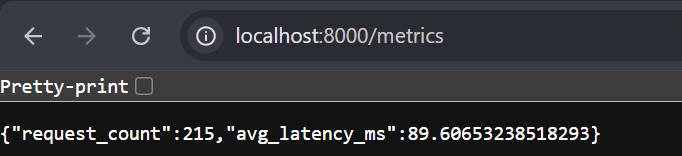

    ```bash
        localhost:8000/health
    ```
    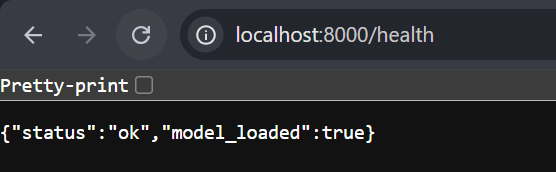

- Test client for inference service

    ```bash
        python inference_client.py --image data\processed\PetImages_224_split\val\Cat\2.jpg --mode file --url http://localhost:8000
    ```
    - Output : Predict: Cat (Class 0)

        ```
        {
            "predictions": [
                {
                "probabilities": [
                    0.8913493156433105,
                    0.10865061730146408
                ],
                "predicted_class": 0,
                "predicted_label": null
                }
            ]
        } 

    ```bash
        python inference_client.py --image C:\ArunDocs\Code\MLOps_Assignment_2_Grp_99\data\processed\PetImages_224_split\val\Dog\5.jpg --mode file --url http://localhost:8000
    ```
    - Output : Predict: Dog (Class 1)

        ```
        {
            "predictions": [
                {
                "probabilities": [
                    0.009738803841173649,
                    0.9902612566947937
                ],
                "predicted_class": 1,
                "predicted_label": null
                }
            ]
        } 

- Test Inference Service
    ```bash
        curl http://localhost:8000/health
    ```
    - Output:

        ```
        {"status":"ok","model_loaded":true}

    ```bash
        curl -X POST "http://localhost:8000/predict" -F "files=@data/processed/PetImages_224_split/test/Cat/111.jpg"
    ```
    - Output:

        ```
        {"predictions":[{"probabilities":[0.9991834759712219,0.0008165583130903542],"predicted_class":0,"predicted_label":null}]}

    ```bash
        curl -X POST "http://localhost:8000/predict" -F "files=@data/processed/PetImages_224_split/test/Dog/0.jpg"
    ```

    - Output:

        ```
        {"predictions":[{"probabilities":[0.005587819032371044,0.9944122433662415],"predicted_class":1,"predicted_label":null}]}

- Test inference service logging

    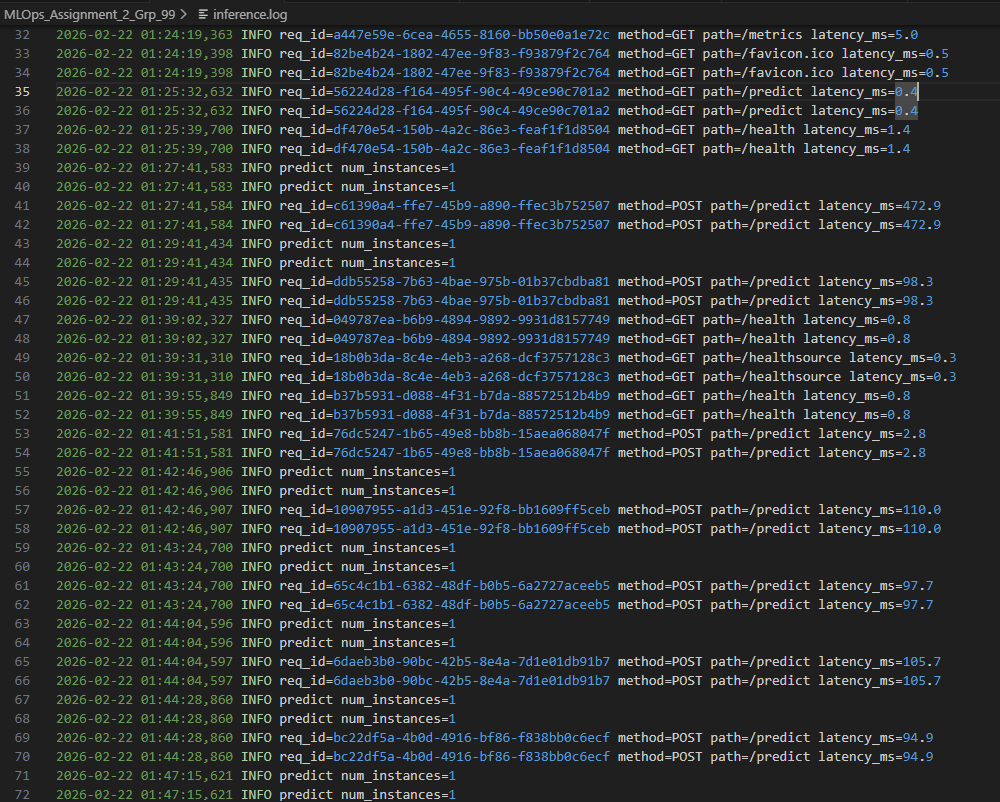

- Test model performance script

    ```bash
        python monitoring/collect_requests.py --url http://localhost:8000 --image-dir data/processed/PetImages_224_split/test --output monitoring/results.csv --limit 100
    ```